<img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/banner-spectral.png" width="1000" align="middle"/>

# <font color='#ECA702'>**Hands-on Sesión 4: Detección Espectral de objetivos 🎯**</font>

# <font color='#4C5FDA'>**Objetivo**</font>


El objetivo de la detección de objetivos hiperespectrales es detectar si un objetivo concreto se encuentra en cada píxel de un cubo de datos hiperespectrales.  En general, los enfoques de detección de objetivos no son eficaces para estimar *cuánto* de un objetivo se encuentra dentro del campo de visión de un píxel (eso sería desmezclar) - sólo si el material está allí o no (con cierta confianza).  

Los algoritmos de detección de objetivos hiperespectrales más utilizados son el *Spectral Matched Filter* (SMF) y el *Adaptive Cosine Estimator* (ACE).  Ambos métodos requieren tener de antemano la firma del blanco que se busca.  Ambos métodos estiman la confianza en el objetivo calculando el coseno del ángulo entre la firma del objetivo y un píxel de prueba en un espacio blanqueado (es decir, tras la normalización del fondo).  La principal diferencia entre ambos métodos es que el SMF tiene en cuenta la magnitud, mientras que el ACE no.  Se calculan del siguiente modo:


$SMF = \frac{\left(\left(\mathbf{s}-\mu\right)^T \Sigma^{-1}\left(\mathbf{x}-\mu\right)\right)^2}{\left(\mathbf{s}-\mu\right)^T \Sigma^{-1}\left(\mathbf{s}-\mu\right)}$

$ACE = \frac{\left(\left(\mathbf{s}-\mu\right)^T \Sigma^{-1}\left(\mathbf{x}-\mu\right)\right)^2}{\left(\mathbf{s}-\mu\right)^T \Sigma^{-1}\left(\mathbf{s}-\mu\right)\left(\mathbf{x}-\mu\right)^T \Sigma^{-1}\left(\mathbf{x}-\mu\right)}$

donde $\mathbf{s}$ es la firma del objetivo, $\mathbf{x}$ es el píxel bajo prueba, $\mu$ es la media del fondo, y $\Sigma$ es la covarianza del fondo.

<img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/ACE.png" width="600" align="middle"/>

<font color='#4C5FDA'>**Estimación de la media y la covarianza del fondo**</font>

A menudo resulta difícil determinar cómo estimar la media y la covarianza del fondo.  Si hay muy pocos objetivos en una escena, puede bastar con utilizar la media y la covarianza globales de la escena para representar el fondo.  También se ha trabajado para segmentar la escena y, a continuación, calcular las estadísticas del fondo para cada segmento.

También hay enfoques en los que las estadísticas de fondo se calculan en un enfoque de "ventana deslizante" para centrarse sólo en la información local durante la estimación del fondo. El problema de estos métodos es determinar el tamaño de la ventana.  Si la ventana es demasiado pequeña, puede tener problemas para estimar las estadísticas de fondo de forma fiable.  Sin embargo, si la ventana es demasiado grande, ya no se utiliza sólo la información local.


<font color='#4C5FDA'>**Informacion de los datos**</font>

El conjunto de datos MUUFL Gulfport incluye 64 objetivos emplazados que varían entre 0,25m^2 y3m2  de tamaño. La resolución espacial del cubo de datos hiperespectrales es de  1m2 . Por lo tanto, el tamaño de estos objetivos varía de superpíxel a subpíxel, y los más pequeños cubren como máximo un cuarto del campo de visión de un píxel (si se encuentra completamente dentro de ese píxel y no abarca múltiples píxeles). Además, los objetivos pueden ser subpíxeles debido a la oclusión de los árboles del campus.

Utilicemos métodos de detección de objetivos para tratar de encontrarlos:

# <font color='#4C5FDA'>**Importamos datos necesarios**</font>

In [1]:
%%capture
!pip install gdown
!gdown --id 1ySjpkoKe2fbM9_WXXId3BxADBHgDnjAi #loadmat
!gdown --id 1duNzN8TR9TGCDNm03nsxeRdHGN6iVzgC #hsi_detectors
!gdown --id 1xMk-YVcaSxSISSdUDDsFWtfBGe4N2k8f #muufl_gulfport_campus_w_lidar_1.mat
!gdown --id 1ISmN6kO38Nsq-tqZvKog9rUv6SUj9GlI #tgt_img_spectra.mat

# <font color='#4C5FDA'>**Importamos librerias**</font>

In [3]:
# Importaciones y configuración
import numpy as np
import os.path
import scipy.io
from loadmat import loadmat

import matplotlib as mpl
%matplotlib inline
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*2
import matplotlib.pyplot as plt

from hsi_detectors import smf_detector,ace_detector

In [4]:
# Cargar la imagen del Campus
img_fname = 'muufl_gulfport_campus_w_lidar_1.mat'
spectra_fname = 'tgt_img_spectra.mat'

dataset = loadmat(img_fname)['hsi']

hsi = dataset['Data']
n_r,n_c,n_b = hsi.shape
wvl = dataset['info']['wavelength']
rgb = dataset['RGB']

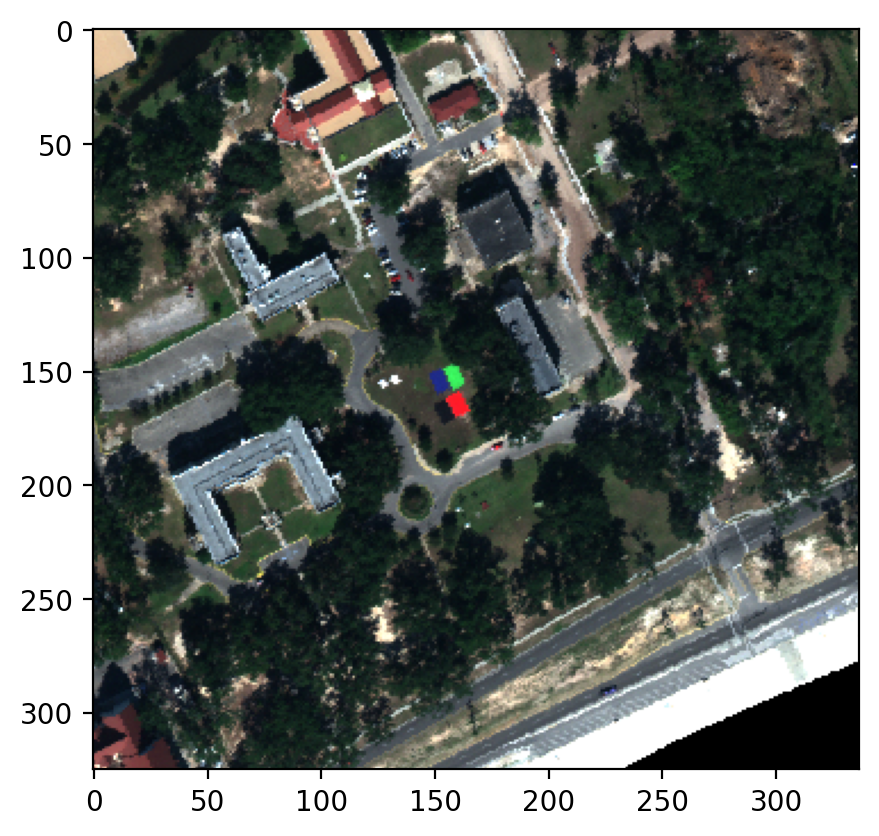

In [5]:
plt.imshow(rgb)
plt.show()

# **<font color='#ECA702'>**<font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font><font color="#0000FF"> #</font><font color="#9400D3">1</font> 💪**</font>
* Cargar las firmas de destino
* Mirar los nombres de los objetivos
* Trazar los espectros de la firma del objetivo y grafocar los espectros de cada objetivo.


In [6]:
# Carga el conjunto de datos de espectros desde un archivo MAT
spectra_dataset = loadmat(spectra_fname)
# Extrae los espectros de los objetivos (targets) del conjunto de datos
tgts = spectra_dataset['tgt_img_spectra']['spectra']
# Extrae los nombres de los objetivos (targets) del conjunto de datos
tgt_names = spectra_dataset['tgt_img_spectra']['names']


In [8]:
# Mira los nombres de los objetivos
tgt_names

array(['brown', 'dark_green', 'faux_vineyard_green', 'pea_green'],
      dtype=object)

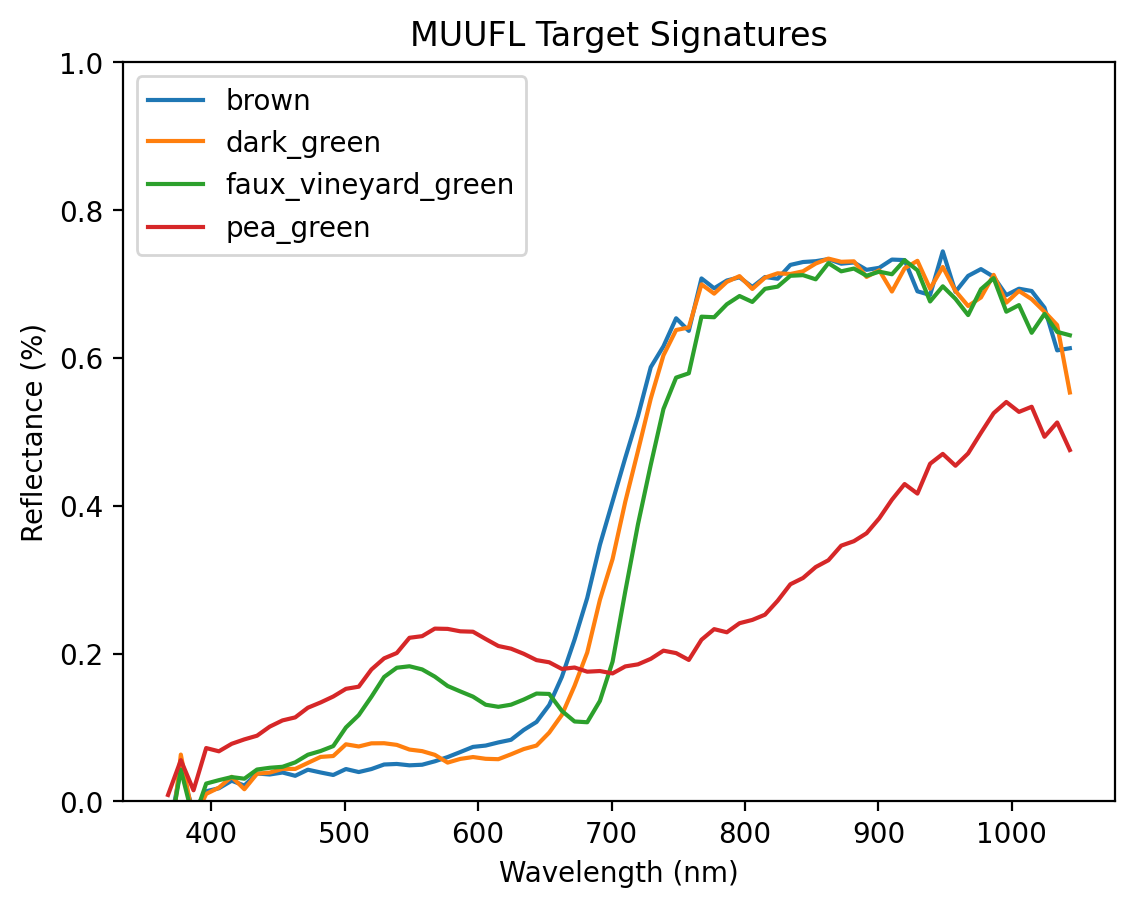

In [9]:
# NO MODIFIQUES ESTA CELDA
# Trazar los espectros de la firma del objetivo y graficarlos

# Recorta los espectros de los objetivos para que coincidan con el número de longitudes de onda disponibles en 'wvl'
trimmed_tgts = tgts[:wvl.shape[0], :]

# Itera sobre cada espectro de objetivo en el conjunto de datos recortado
for i in range(trimmed_tgts.shape[1]):
    # Grafica el espectro del objetivo i contra las longitudes de onda
    plt.plot(wvl, trimmed_tgts[:, i], label=tgt_names[i])

plt.legend()
plt.ylim(0, 1)
plt.ylabel('Reflectance (%)')
plt.xlabel('Wavelength (nm)')
plt.title('MUUFL Target Signatures')
plt.show()

# **<font color='#ECA702'>**<font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font><font color="#0000FF"> #</font><font color="#9400D3">2</font> 💪**</font>

* Seleccionar uno de los objetivos anteriormente encontrados e intentar encontrarlo en la imagen usando el algoritmo ACE (Estimador de Coseno Adaptativo)
* Trazar el mapa de confianza ACE
* Umbralizar al mapa de confianza ACE para hacer encontrar el objetivo seleccionado en la imagen.


<ipython-input-17-45136cec49ab>:3: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wvl, target, label=tgt_names) # Traza el espectro del objetivo<


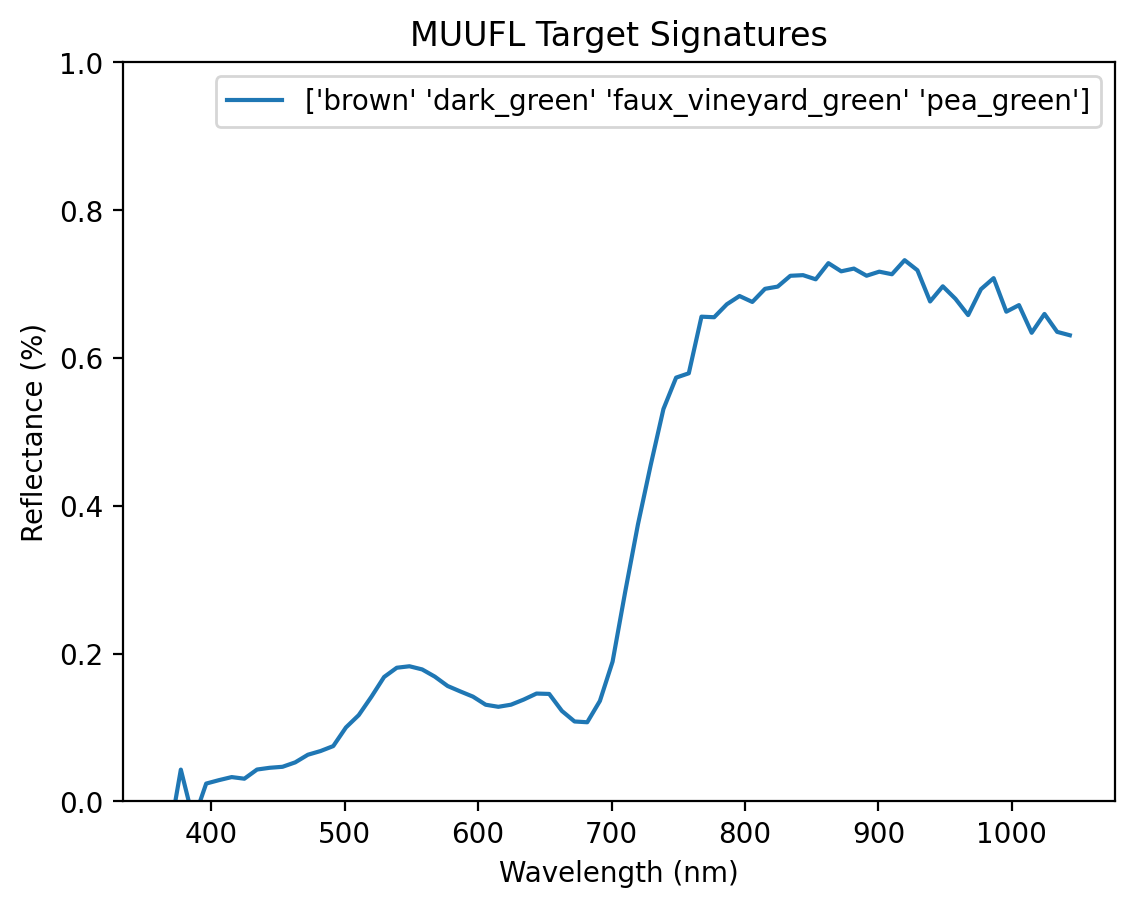

In [17]:
# seleccionar los espectros para el objetivo que desees
target = tgts[:,2] # Elije el objetivo deseado a partir de los mostrados anteriormente
plt.plot(wvl, target, label=tgt_names) # Traza el espectro del objetivo<
plt.legend()
plt.ylim(0, 1)
plt.ylabel('Reflectance (%)')
plt.xlabel('Wavelength (nm)')
plt.title('MUUFL Target Signatures')
plt.show()

In [18]:
# La funcion ACE recibe dos parametros: conjunto de datos y un objetivo espectral específico
conf_ace = ace_detector(hsi, target) # Evalúa el algoritmo ACE

Text(0.5, 1.0, 'ACE Confidence Map')

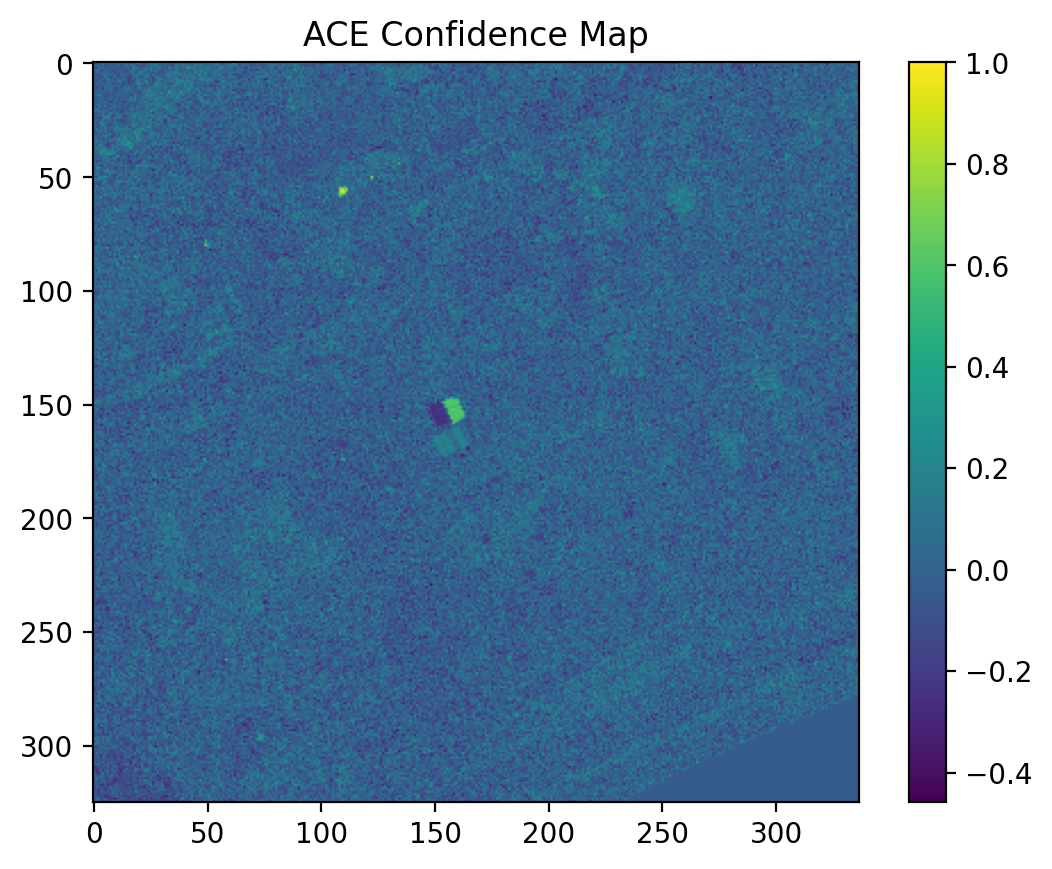

In [19]:
# trazar el mapa de confianza ACE
# La confianza ACE oscila entre -1 y 1, siendo -1 de baja confianza y 1 de alta confianza.
plt.imshow(conf_ace)
plt.colorbar()
plt.title('ACE Confidence Map')

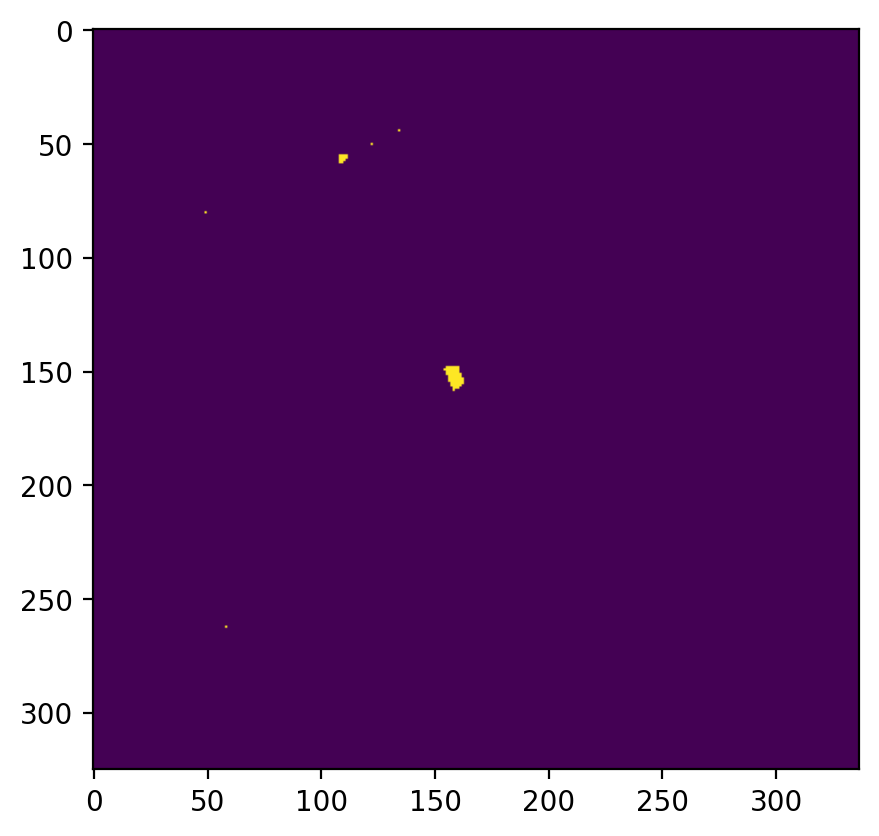

In [21]:
# Aplicar el umbral al mapa de confianza para hacer declaraciones de objetivos
# Selecciona todos los píxeles con una confianza superior a 0,5
plt.imshow(conf_ace > 0.5)

# **<font color='#ECA702'>**<font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font><font color="#0000FF"> #</font><font color="#9400D3">3</font> 💪**</font>
* Seleccionar uno de los objetivos anteriormente encontrados e intentar encontrarlo en la imagen usando el algoritmo SMF (Filtro Espectral Coincidente)
* Trazar el mapa de confianza SMF
* Umbralizar al mapa de confianza SMF para hacer encontrar el objetivo seleccionado en la imagen.

Text(0.5, 1.0, 'SMF Confidence Map')

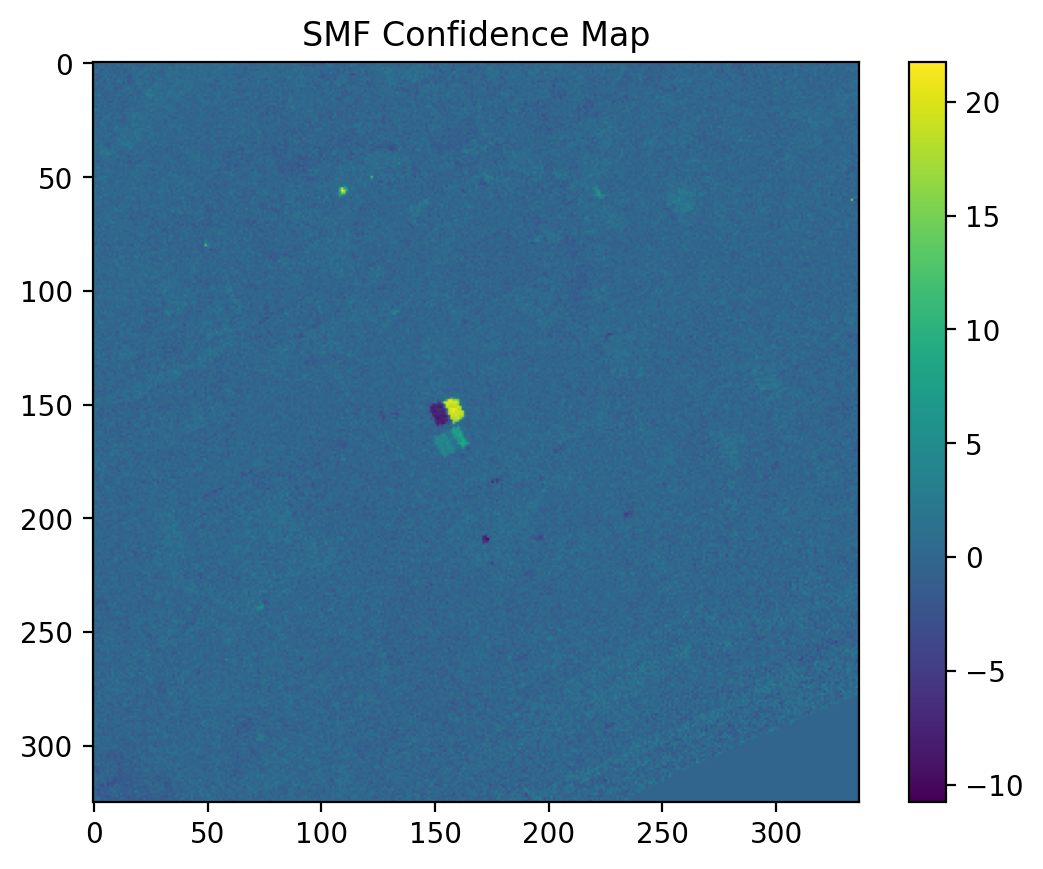

In [28]:
# Ejecutar la misma firma espectral en el Filtro Espectral Coincidente (SMF)
# La funcion SMF recibe dos parametros: conjunto de datos y un objetivo espectral específico

conf_smf = smf_detector(hsi, target) # Evalúa el algoritmo SMF
plt.imshow(conf_smf)
plt.colorbar()
plt.title('SMF Confidence Map')

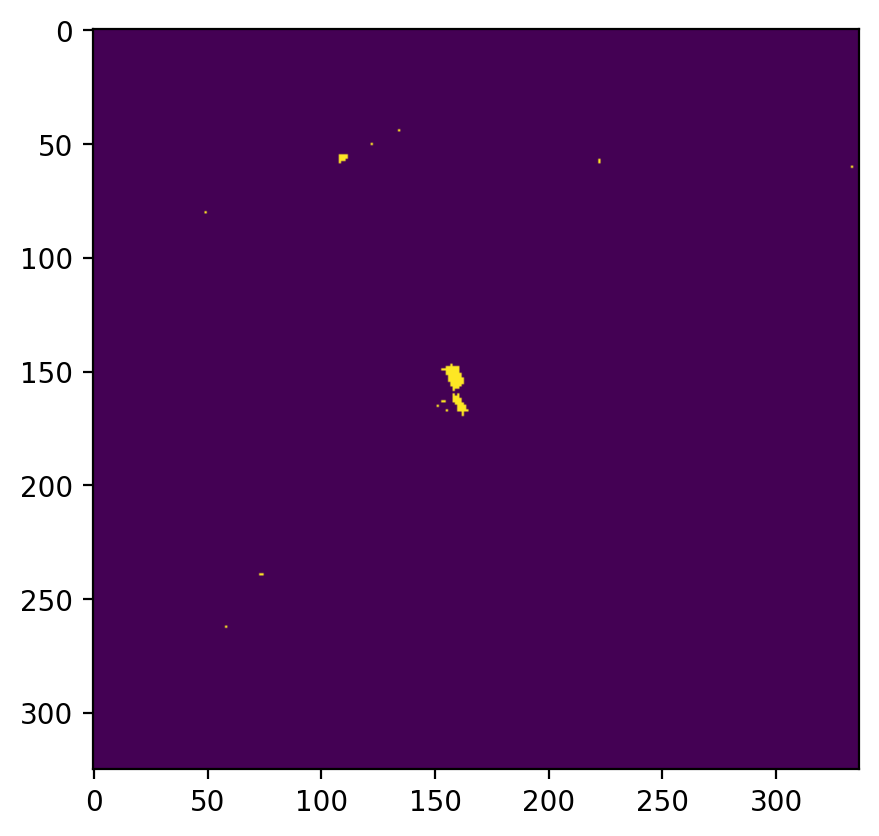

In [23]:
# Aplicar el umbral para hacer declaraciones
# Selecciona todos los píxeles con una confianza superior al 5
plt.imshow(conf_smf > 5)

In [24]:
# NO MODIFIQUES ESTA CELDA

# cargar las ubicaciones de los objetivos de la verdad sobre el terreno
gt = dataset['groundTruth']

# Extrae tres tipos de información para cada objetivo: índices de fila, índices de columna y nombres/tipos
gt_row,gt_col,gt_name = gt['Targets_rowIndices'],gt['Targets_colIndices'],gt['Targets_Type']

# Crea una lista de tuplas con las coordenadas (fila, columna) de los objetivos elegidos
br_rc = [(row,col) for row,col,name in zip(gt_row,gt_col,gt_name) if name == tgt_names[0]]


In [ ]:
br_rc

[(np.uint16(137), np.uint16(236)),
 (np.uint16(121), np.uint16(226)),
 (np.uint16(105), np.uint16(218)),
 (np.uint16(181), np.uint16(243)),
 (np.uint16(200), np.uint16(234)),
 (np.uint16(215), np.uint16(253)),
 (np.uint16(223), np.uint16(256)),
 (np.uint16(187), np.uint16(227)),
 (np.uint16(191), np.uint16(213)),
 (np.uint16(231), np.uint16(180)),
 (np.uint16(222), np.uint16(176)),
 (np.uint16(211), np.uint16(172)),
 (np.uint16(238), np.uint16(147)),
 (np.uint16(264), np.uint16(95)),
 (np.uint16(293), np.uint16(143))]

# **<font color="#FF0000">E</font><font color="#FF7F00">x</font><font color="#FFFF00">t</font><font color="#00FF00">r</font><font color="#0000FF">a</font>:** Realizar la comparación de los dos algoritmos con el ground truth en una gráfica.

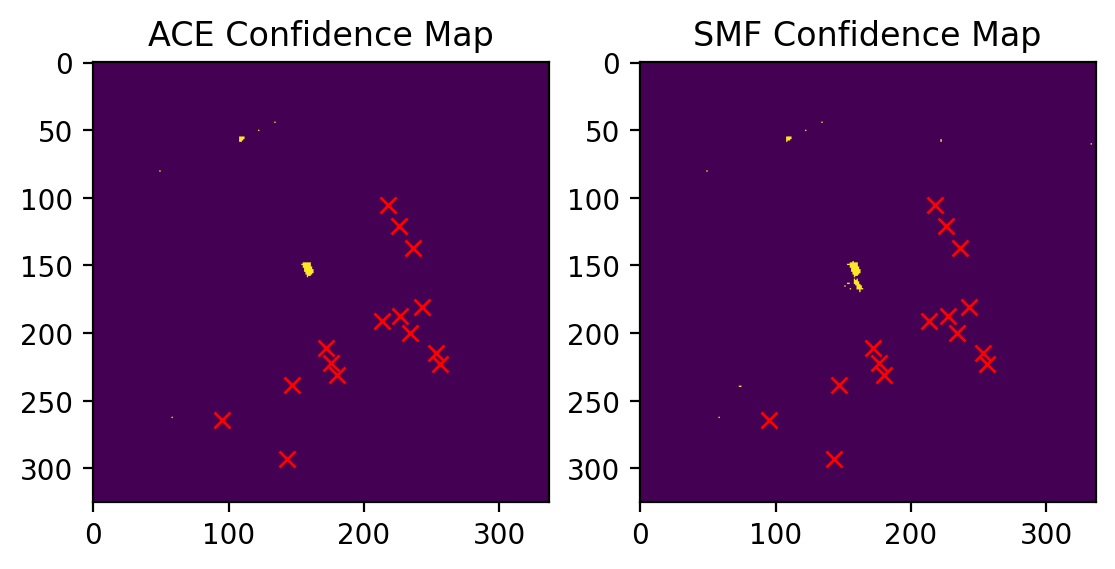

In [29]:
# Trazar el ground truth en el mapa de declaración
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(conf_ace>0.5)
for r,c in br_rc:
    plt.plot(c,r,'rx')
plt.title('ACE Confidence Map')
plt.subplot(1,3,2)
plt.imshow(conf_smf>5)
for r,c in br_rc:
    plt.plot(c,r,'rx')
plt.title('SMF Confidence Map')
plt.show()